# Breweries
#### This file represents information received from venue APIs
* **FourSquare**
    - presents the fewest breweries & appears inaccurate
    - https://location.foursquare.com/developer/reference/place-search
* **Google Maps API**
    - presents many breweries, however, appears to be missing several breweries in comparison to **coloradobrewerylist.com**
* **<coloradobrewerylist.com/brewery>.**
    - appears to be the most comprehensive, missing the fewest breweries (craft, large breweries, etc.)

In [1]:
import os                       # For working in different directories
import numpy as np              # Data Libraries
import pandas as pd             # Data Libraries
import matplotlib.pyplot as plt # Visualization Library
import seaborn as sns           # Visualization Library
import folium                   # Visualization Library
from folium.features import DivIcon # geospatial library 
# from folium.features import GeoJsonTooltip    # Visualization Library
import geopandas as gpd         # geospatial library 
from shapely.geometry import Point # geospatial library 
import io                       # to work w/ images (static Folium map save)
# from PIL import Image           # images
import PIL

import yaml                     # working w/ config file

import requests
import json
from bs4 import BeautifulSoup   # parsing HTML
import time
from selenium import webdriver 
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import glob

In [2]:
def load_api_key(directory):
    """Function to load API key w/out explicitily providing it in this public-facing file."""
    path = directory
    os.chdir(path)
    with open('config.yaml', 'r') as file:
        file_contents = yaml.safe_load(file)
    
    return file_contents['api_key'] 


foursquare_api_key = load_api_key('/home/jcorley60/Documents/project_portfolio/\
DenverCraftBreweries/data/Breweries/Foursquare')

# Points (Latitude, Longitude) for API calls
* Both FourSquare & Google APIs limit the number of places returned in results and therefore we need multiple latitude and longitude pairs to comprehensivly cover breweries w/in the Denver-Lakewood-Aurora MSA.

### folium map of Denver MSA w/ superimposed circles representing our latitude, longitude pairs, therefore indicating our coverage of the MSA
* we know from the exhaustive source coloradobrewerylist.com/brewery that there will be < 460 breweries in the Denver MSA (460 represents all breweries state-wide)
    - FourSquare: 50 results per GET request --> 450 / 50 = 9-points
    - Google Maps Platform Places: 60 results per GET request --> 450 / 60 = 7.5-points
    - these numbers represent a minimum, however, we find the respective webservers will not limit our GET requests for our usage (nor are we out of compliance) and therefore can send more than 8 or 9 points requests to ensure comprehensive brewery coverage

### Plot  MSA Places/refresh memory on `DenverCraftBreweries_geography.ipynb`

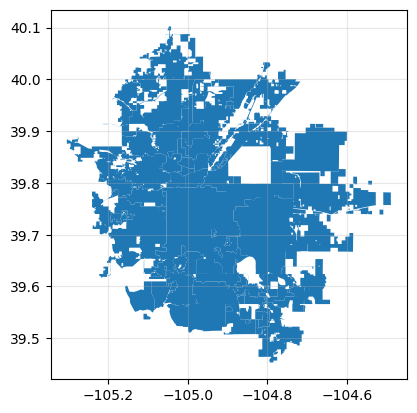

Column 'num_breweries' not found


,GEO_ID,NAME,NAMELSAD,ALAND,AWATER,geometry,num_major_roads,num_colleges,num_medical_facilities,num_airports
0,1600000US0824950,Erie,Erie town,53222659,260609,"POLYGON ((-105.10469 40.01455, -105.10380 40.0...",11,0,0,1
1,1600000US0850026,Meridian Village,Meridian Village CDP,1319424,0,"POLYGON ((-104.83001 39.52793, -104.82992 39.5...",0,0,0,0
2,1600000US0869480,Shaw Heights,Shaw Heights CDP,1814251,2011,"POLYGON ((-105.05042 39.86008, -105.04054 39.8...",1,0,0,0
3,1600000US0852350,Mountain View,Mountain View town,240817,0,"POLYGON ((-105.06019 39.77661, -105.05325 39.7...",2,0,0,0
4,1600000US0812815,Centennial,Centennial city,77035924,379304,"MULTIPOLYGON (((-104.97913 39.56942, -104.9769...",9,0,1,0


In [3]:
os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/\
data/US Census Bureau/American Community Survey'
)

gdf_msa_places = pd.read_pickle('gdf_msa_places.pkl')
gdf_msa_places.plot();
plt.grid(alpha=0.3)
plt.show()

try:
    gdf_msa_places.drop(columns=['num_breweries'], axis=1, inplace=True)
except:
    print("Column 'num_breweries' not found")
gdf_msa_places.head()

In [4]:
def plot_circle_and_text_overlay(folium_map, lat, lon, radius, color, overlayMarkers=False):
    """
    This function will plot out circles based off of a latitude, longitude coordinate pair and a radius.
    
    References:
    https://python-visualization.github.io/folium/latest/user_guide/vector_layers/circle_and_circle_marker.html
    https://stackoverflow.com/questions/46400769/numbers-in-map-marker-in-folium
    params:
    folum_map{folium map object} - map upon which layers are added
    lat{float} - latitude coordindate for point
    lon{float} - longitude coordindate for point
    radius{} - radius in meters from coordinate pair
    color{string} - color used for circle marker
    overlayMarkers{bool} - if True will overlay marker object text onto circles
    returns:
    Folium map layer(s) which will need a base map to overlay upon
    1) Circle{Folium Circle object} - circles are overlaid upon a given Folium base map
    """
    folium.Circle(
        location=[lat, lon],
        radius=radius,
        color="black",
        fill=False,
        fill_opacity=0.6,
        fill_color=color,
        weight=1,
        opacity=1,
        popup=f"({round(float(lat),3)}, {round(float(lon),3)}), r={round(radius/1609.344)}-miles",
        tooltip=f"{round(radius / 1609.344)}-mile radius from point ({lat}, {lon})",  # 1-mile = 1,609.344-meters
    ).add_to(base_map)

    if overlayMarkers:
        folium.map.Marker(
            [lat - 0.005, lon - 0.05],    # offsets for text centering w/in Circle
            icon=DivIcon(
                icon_size=(150, 36),
                icon_anchor=(7, 20),
                html=f'<div style="font-size: 9pt; \
                color:black">({round(float(lat),3)}, {round(float(lon),3)})\
                <br>{round(radius/1609.344)}-mile radius</br></div>'
            )
        ).add_to(base_map)


# Since APIs will not return all results as they purposefully limit returned results
# select coordinates for API queries to ensure full coverage of MSA as determined in '..._geographies.ipynb'
api_coords = [
    (39.7737, -104.9579),    # River North area (RiNo), anticipated higher brewery density
    (39.750993, -104.990017),    # downtown Denver, anticipated higher brewery density
    (39.7325, -104.9675),    # East Colfax
    (39.7413, -104.7996),    # Aurora near East Colfax & 
    (39.7473, -104.6516),    # East of Aurora: Arapahoe County
    (39.6987, -104.8068),    # Aurora near 
    (39.6242, -104.75),    # Aurora encompassing Aurora Reservoir, partially
    (39.613, -104.9359),    # centered on DTC
    (39.5358, -104.8219),    # gap: SE Denver
    (39.8539, -104.8508),    # NE Denver: Rocky Mountain Aresenal
    (39.8412, -104.6887),    # DIA
    (39.6321, -105.0815),    # SW Denver
    (39.7632, -105.1556),    # West Denver
    (39.7, -105.125),    # Central Lakewood, anticipated higher brewery density
    (39.9382, -105.0911),    # NNW Denver
    (39.8476, -105.0842),    # NW Denver
    (39.9129, -104.9689),    # NNE Denver
]

print(f"{len(api_coords)} API coordinate pairs")
colors = ['red', 'blue', 'green', 'yellow', 'tan', 'purple', 'orange', 'silver']
base_map = folium.Map(tiles='OpenStreetMap', location=[39.755, -104.9], zoom_start=10)
for i in range(len(api_coords)):
    # use modulo operator to obtain different colored circles (otherwise all blue by default)
    color = colors[i % len(colors)]
    plot_circle_and_text_overlay(
        base_map, 
        api_coords[i][0], 
        api_coords[i][1], 
        8046.72, 
        color, 
        overlayMarkers=True
    )
# Add ability to click and obtain Latitude-Longitude Coordinate pairs for non-circular points on map
base_map.add_child(folium.LatLngPopup())

# SAVE MAP
# to HTML file
# base_map.save("/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/data/Breweries/api_coords.html")

base_map

17 API coordinate pairs


# `FourSquare`

In [5]:
def send_foursquare_api_get_request(
    api_key, 
    distance='24140', 
    lat='39.748', 
    lon='-104.8', 
    statusCode=False
):
    """
    Function to send and save Foursquare API requests as JSON files.
    https://location.foursquare.com/developer/recipes/place-search-using-latlong
    https://location.foursquare.com/developer/reference/v2-rate-limits
    Returned GET results are limited to 50 venues by FourSquare.
    
    Per returned header, and rate limit document explanation:
        - X-RateLimit-Limit: 360000 - This header typically indicates the maximum number of requests you 
            are allowed to make within a specific time frame (e.g., per hour or per day).
        - X-RateLimit-Reset: 1698105998 - This header often shows a timestamp (in Unix time) indicating when 
            your rate limit will reset. After this time, you will regain access to the full rate limit.
        - X-RateLimit-Remaining: 359961 - This header usually tells you how many requests you have left within 
            the current rate limit window.
    params:
    api_key{str} - api key needed to send FourSquare a GET request
    distance{str} - radius, in meters, from latitude, longitude coordinate pair
    lat{str} - latitude of coordinate
    lon{str} - longitude of coordiate
    statusCode{bool} - if True provides GET request status code returned in result
    returns:
    foursquare_result{JSON object} - JSON object which is subsequently written to file
    """
    # select desired folder for saving JSON return files
    os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/data/Breweries/Foursquare/backups')
    
    # Determine if any other files exist in series or if intial file
    max_file_number = 0
    for file in glob.glob('foursquare_result_*.json'):
        if int(file.split('_')[-1].split('.json')[-2]) > max_file_number:
            max_file_number = int(file.split('_')[-1].split('.json')[-2])
    
    url = "https://api.foursquare.com/v3/places/search"
    params = {
        "categories": "13029",    # category id for breweries    
        "ll": lat + ',' + lon,    # https://location.foursquare.com/places/docs/categories
        "distance": distance,  # radius parameter in meters,1-mile=1609.344-meters; boundary of city is ~5-mi
#         "sort":"DISTANCE",
        "limit": "50",    # returned results limited to 50 entries; default is 10?
#         "open_now": "true",   # is the venue open right now at the time of the GET request?
    }
    headers = {
        "Accept": "application/json",
        "Authorization": api_key
    }
    time.sleep(1)
    foursquare_response = requests.request("GET", url, params=params, headers=headers)
    
    if statusCode is True:
        print("STATUS CODE:", foursquare_response.status_code)
        
    foursquare_result = foursquare_response.json()
    
    # save FourSquare API response as a JSON file - print if exception encountered
    try:
        filename = f"foursquare_result_{max_file_number + 1}.json" 
        with open(filename, 'w') as fp:
            json.dump([foursquare_result], fp)    # JSON format requires an outer array
    except IOError as e:
        print(f"Couldn't write to file ({e}): {filename}")
        
    return foursquare_result

### Send FourSquare API GET Requests & Save Results as JSON files
* Rate limit: see doc string above for `send_foursquare_api_get_request()`

In [6]:
for coord in api_coords:
    last_foursquare_result = send_foursquare_api_get_request(
        foursquare_api_key, 
        distance='8046.72',    # 5-mile (or 8,046.72 meters) radius per coordinate pair: (lat, long)
        lat=str(coord[0]), 
        lon=str(coord[1]),
        statusCode=False
)

In [7]:
def parse_foursquare_api_result(foursquare_result):
    """Parse FourSquare returned GET request results.
    params: foursqaure_result{JSON file} - JSON file obtained from FourSquare API GET request
    returns: dict_results{dictionary} - a dictionary representing parsed results of JSON file
    """
    dict_results = {
        'name': [],
        'category': [],
        'lat': [], 
        'lon': [], 
        'chain_biz': [],
        'addr_full': [],
        'addr_st': [],
        'addr_locale': [],
        'addr_zip': [],
        'addr_region': [],
    }

    for i in foursquare_result['results']:
        # extract desired info from results
        name = i['name']
        category = [i['categories'][j]['name'] for j in range(len(i['categories']))]
        category = ", ".join(category)
        lat, lon = i['geocodes']['main']['latitude'], i['geocodes']['main']['longitude']
        chain_biz = ["Y" if i['chains'] else "N"][0]
        addr_full = i['location']['formatted_address']
        addr_st = i['location']['address']
        addr_locale = i['location']['locality']
        addr_zip = i['location']['postcode']
        addr_region = i['location']['region']

        addr_st = i['location']['address']

        # create dictionary of select info from results
        dict_results['name'].append(name)
        dict_results['category'].append(category)
        dict_results['lat'].append(lat)
        dict_results['lon'].append(lon)
        dict_results['chain_biz'].append(chain_biz)
        dict_results['addr_full'].append(addr_full)
        dict_results['addr_st'].append(addr_st)
        dict_results['addr_locale'].append(addr_locale)
        dict_results['addr_zip'].append(addr_zip)
        dict_results['addr_region'].append(addr_region)
    
    return dict_results

### Open all saved FourSquare JSON files in series and create a singular overarching dataframe
* once created drop duplicates, reset the index, and drop the column `addr_region` which is always 'CO'

In [8]:
os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/data/Breweries/Foursquare/backups')

list_foursquare_dfs = []

# iterate through all JSON files, opening them and creating dataframes which are appended to a single list
for idx, file in enumerate(glob.glob('foursquare_result_*.json')):
    with open(file, 'r') as fp:   
        foursquare_result = json.load(fp)
        dict_results = parse_foursquare_api_result(foursquare_result[0])    
        df = pd.DataFrame(dict_results)
        print(f"{idx + 1: <2}: {df.shape}")
        list_foursquare_dfs.append(df)

print(len(list_foursquare_dfs), "df's w/ 50 rows each =", len(list_foursquare_dfs) * 50, "total rows")

# concatenate all dataframes added to single list
df_foursquare_breweries = pd.concat(list_foursquare_dfs, axis=0, ignore_index=True)
df_foursquare_breweries.drop_duplicates(inplace=True)          # drop all duplicates
df_foursquare_breweries.reset_index(inplace=True, drop=True)   # reset index for new singular overarching dataframe
df_foursquare_breweries.drop(['addr_region'], axis=1, inplace=True)    # drop column which tells us 'CO' is addr state
df_foursquare_breweries

1 : (50, 10)
2 : (50, 10)
3 : (50, 10)
4 : (50, 10)
5 : (50, 10)
6 : (50, 10)
7 : (50, 10)
8 : (50, 10)
9 : (50, 10)
10: (50, 10)
11: (50, 10)
12: (50, 10)
13: (50, 10)
14: (50, 10)
15: (50, 10)
16: (50, 10)
17: (50, 10)
17 df's w/ 50 rows each = 850 total rows


,name,category,lat,lon,chain_biz,addr_full,addr_st,addr_locale,addr_zip
0,Great Divide Barrel Bar,"Beer Bar, Brewery, Restaurant",39.770364,-104.979275,N,"1812 35th St (Brighton Blvd.), Denver, CO 80216",1812 35th St,Denver,80216
1,Ratio Beerworks,"Beer Bar, Brewery, Restaurant",39.761672,-104.981072,N,"2920 Larimer St (29th St.), Denver, CO 80205",2920 Larimer St,Denver,80205
2,Odell Brewing Company,"Beer Garden, Brewery",39.762268,-104.981160,N,"2945 Larimer St, Denver, CO 80205",2945 Larimer St,Denver,80205
3,Our Mutual Friend Malt & Brew,"Beer Bar, Brewery, Restaurant",39.760494,-104.982503,N,"2810 Larimer St, Denver, CO 80205",2810 Larimer St,Denver,80205
4,Station 26 Brewing Co.,"Bar, Brewery, Restaurant",39.769628,-104.905929,N,"7045 E 38th Ave, Denver, CO 80207",7045 E 38th Ave,Denver,80207
...,...,...,...,...,...,...,...,...,...
105,Left Hand Brewing Company,"Bar, Brewery",40.158510,-105.115461,N,"1265 Boston Ave (at Sunset St.), Longmont, CO ...",1265 Boston Ave,Longmont,80501
106,Wibby Brewing Company,Brewery,40.162343,-105.100129,N,"209 Emery St (2nd), Longmont, CO 80501",209 Emery St,Longmont,80501
107,Twisted Pine Brewing Co.,"Bar, Brewery, Pizzeria",40.020715,-105.251180,N,"3201 Walnut St (32nd St.), Boulder, CO 80301",3201 Walnut St,Boulder,80301
108,Gordon Biersch Brewery Restaurant,"Bar, Brewery, American Restaurant",39.930623,-105.135325,Y,"1 W Flatiron Crossing Dr, Broomfield, CO 80021",1 W Flatiron Crossing Dr,Broomfield,80021


### Create GeoDataFrame w/ Latitude & Longitude coordinates & then Pickle

In [9]:
os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/data/Breweries/Foursquare')

geometry = [Point(xy) for xy in zip(df_foursquare_breweries.lon, df_foursquare_breweries.lat)]
df_foursquare_breweries.drop(['lon', 'lat'], axis=1)
gdf_foursquare_breweries = gpd.GeoDataFrame(df_foursquare_breweries, crs="EPSG:4269", geometry=geometry)
gdf_foursquare_breweries.rename(columns={'name': 'brewery'}, inplace=True)

#### NOTE: FourSquare is missing a number of breweries for Golden, including CODA and the 2nd Barrels & Bottles in Golden, CO off of South Golden Road; this area is considered unincorporated Jefferson County and these places will typically have a Golden address, or possibly West Pleasant View.

### Limit FourSquare Results to Breweries w/in approximate Denver-Lakewood-Aurora MSA

In [10]:
os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/data/Breweries/Foursquare')
gdf_msa_foursquare_breweries = gpd.sjoin(gdf_foursquare_breweries, gdf_msa_places, predicate='intersects')
gdf_msa_foursquare_breweries.drop(columns=['index_right', 'NAME'], inplace=True)
gdf_msa_foursquare_breweries.to_pickle('gdf_msa_foursquare_breweries.pkl')
gdf_msa_foursquare_breweries

,brewery,category,lat,lon,chain_biz,addr_full,addr_st,addr_locale,addr_zip,geometry,GEO_ID,NAMELSAD,ALAND,AWATER,num_major_roads,num_colleges,num_medical_facilities,num_airports
0,Great Divide Barrel Bar,"Beer Bar, Brewery, Restaurant",39.770364,-104.979275,N,"1812 35th St (Brighton Blvd.), Denver, CO 80216",1812 35th St,Denver,80216,POINT (-104.97928 39.77036),1600000US0820000,Denver city,396460127,4275563,57,3,8,1
1,Ratio Beerworks,"Beer Bar, Brewery, Restaurant",39.761672,-104.981072,N,"2920 Larimer St (29th St.), Denver, CO 80205",2920 Larimer St,Denver,80205,POINT (-104.98107 39.76167),1600000US0820000,Denver city,396460127,4275563,57,3,8,1
2,Odell Brewing Company,"Beer Garden, Brewery",39.762268,-104.981160,N,"2945 Larimer St, Denver, CO 80205",2945 Larimer St,Denver,80205,POINT (-104.98116 39.76227),1600000US0820000,Denver city,396460127,4275563,57,3,8,1
3,Our Mutual Friend Malt & Brew,"Beer Bar, Brewery, Restaurant",39.760494,-104.982503,N,"2810 Larimer St, Denver, CO 80205",2810 Larimer St,Denver,80205,POINT (-104.98250 39.76049),1600000US0820000,Denver city,396460127,4275563,57,3,8,1
4,Station 26 Brewing Co.,"Bar, Brewery, Restaurant",39.769628,-104.905929,N,"7045 E 38th Ave, Denver, CO 80207",7045 E 38th Ave,Denver,80207,POINT (-104.90593 39.76963),1600000US0820000,Denver city,396460127,4275563,57,3,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,Mother Tucker Brewery,"Bar, Brewery, Restaurant",39.913359,-104.956317,N,"2360 E 120th Ave, Thornton, CO 80233",2360 E 120th Ave,Thornton,80233,POINT (-104.95632 39.91336),1600000US0877290,Thornton city,94522392,5243866,13,0,1,0
87,Gravity Brewing,"Beer Bar, Brewery",39.976066,-105.128462,N,"1150 Pine St (at Hwy 42), Louisville, CO 80027",1150 Pine St,Louisville,80027,POINT (-105.12846 39.97607),1600000US0846355,Louisville city,20643693,288084,7,0,1,0
98,12 Degree Brewing,"Bar, Brewery, Pizzeria",39.978334,-105.131899,N,"820 Main St (Pine), Louisville, CO 80027",820 Main St,Louisville,80027,POINT (-105.13190 39.97833),1600000US0846355,Louisville city,20643693,288084,7,0,1,0
100,Crystal Springs Brewing Company,"Beer Bar, Brewery, Restaurant",39.976039,-105.131841,N,"604 Main St (Elms St), Louisville, CO 80027",604 Main St,Louisville,80027,POINT (-105.13184 39.97604),1600000US0846355,Louisville city,20643693,288084,7,0,1,0


In [11]:
gdf_msa_foursquare_breweries[gdf_msa_foursquare_breweries['addr_locale'].str.contains("Golden")]

,brewery,category,lat,lon,chain_biz,addr_full,addr_st,addr_locale,addr_zip,geometry,GEO_ID,NAMELSAD,ALAND,AWATER,num_major_roads,num_colleges,num_medical_facilities,num_airports
43,New Terrain Brewing Company,"Beer Bar, Brewery, Restaurant",39.779647,-105.186165,N,"16401 Table Mountain Pkwy, Golden, CO 80403",16401 Table Mountain Pkwy,Golden,80403,POINT (-105.18617 39.77965),1600000US0830835,Golden city,24952585,239970,11,1,0,0
48,Golden City Brewery,"Brewery, Pizzeria",39.754651,-105.223545,N,"920 12th St (at Cheyenne St.), Golden, CO 80401",920 12th St,Golden,80401,POINT (-105.22355 39.75465),1600000US0830835,Golden city,24952585,239970,11,1,0,0
92,Mountain Toad Brewing,"Bar, Brewery, Restaurant",39.758110,-105.224245,N,"900 Washington Ave (9th St.), Golden, CO 80401",900 Washington Ave,Golden,80401,POINT (-105.22424 39.75811),1600000US0830835,Golden city,24952585,239970,11,1,0,0
94,Cannonball Creek Brewing Company,"Beer Bar, Beer Garden, Brewery",39.768707,-105.234822,N,"393 Washington Ave (Highway 93), Golden, CO 80403",393 Washington Ave,Golden,80403,POINT (-105.23482 39.76871),1600000US0830835,Golden city,24952585,239970,11,1,0,0
96,Coors Brewing Company,Brewery,39.756038,-105.217501,N,"300 12TH St, Golden, CO 80401",300 12TH St,Golden,80401,POINT (-105.21750 39.75604),1600000US0830835,Golden city,24952585,239970,11,1,0,0


# `Google Maps Platform`
## Places API
> https://developers.google.com/maps/documentation/places/web-service
> * https://github.com/googlemaps/google-maps-services-python/blob/master/googlemaps/places.py
* Google Maps obtains vendor information from various sources, including third-party data providers, user-generated content, and publicly available information on the internet. 
* Google uses a combination of automated algorithms and manual processes to collect and verify data about businesses and other points of interest.

In [12]:
google_api_key = load_api_key('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/\
data/Breweries/Google Maps Platform')

def send_google_place_api_get_request(
    api_key, 
    lat='39.748', 
    lon='-104.8', 
    radius='24140', 
    keyword='brewery',
    printOutput=False
):
    """Google designed their API such that only 20-results are returned at a time, however,
    a 'next_page_token' is included in the initial API return result which can be used to grab
    successive page results for up to 3 'pages' (up to 20-results per page) total (or 60-results total).  
    Google provides a $200 free credit as of 10/20/2023.
    NOTE: if an optional parameter in the URL GET request is not recognized it will be ignored by server
    params:
    api_key{str} - api key needed to send Google server a GET request
    lat{str} - latitude of coordinate
    lon{str} - longitude of coordiate
    radius{str} - radius, in meters, from latitude, longitude coordinate pair
    keyword{str} - word used to search venues, default is 'brewery'
    printOutput{bool} - if True prints summary output of all files created
    returns:
    none - JSON file(s) is automatically written
    """
    # select desired folder for saving JSON return files
    os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/\
data/Breweries/Google Maps Platform/backups')
    
    # Determine if any other files exist in series or if intial file
    max_file_number = 0
    for file in glob.glob('google_result_*.json'):
        if int(file.split('_')[-2]) > max_file_number:
            max_file_number = int(file.split('_')[-2])
    
    # https://developers.google.com/maps/documentation/places/web-service/search-nearby#required-parameters
    # radius parameter is in meters, 15-miles=~24,140-meters which is rough boundary of city from center
    base_url = f'https://maps.googleapis.com/maps/api/place/nearbysearch/json?\
    &keyword={keyword}\
    &location={lat},{lon}\
    &radius={radius}\
    &atmosphere=serves_beer\
    &key={api_key}'
        
    response = requests.request("GET", base_url)
    dict_result = response.json()    # response.json() creates a dictionary
    token = dict_result.get('next_page_token', None)    # if 'next_page_token' DNE then no error thrown
    
    # save initial Google API response as a JSON file
    with open(f'google_result_{max_file_number + 1}_1st.json', 'w') as fp:
        json.dump([dict_result], fp)    # JSON format requires an outer array
    
    # Get more place results as Google limits return response to 20 places
    # https://developers.google.com/maps/documentation/places/web-service/search-nearby#PlaceSearchPaging
    count = 1   
    while token != None:
        count += 1
         # per docs when parameter 'pagetoken' passed all other params ignored
        next_url = f"https://maps.googleapis.com/maps/api/place/nearbysearch/json?key={api_key}&pagetoken={token}"
        time.sleep(2.5)    # Pause #-seconds - pause required by GoogleAPI prior to accessing additional page(s)
        new_response = requests.request('GET', next_url)
        new_dict_result = new_response.json()
        new_token = new_response.json().get('next_page_token', None)
        token = new_token
        
        # save subsequent Google API response as a JSON file
        if count == 2:
            suffix = '2nd'
        if count == 3:
            suffix = '3rd'
            
        with open(f'google_result_{max_file_number + 1}_{suffix}.json', 'w') as fp:
            json.dump([new_dict_result], fp)
    
    if printOutput:
        if count == 1:
            print(f"'google_response_{max_file_number + 1}_1st.json' generated for ({round(float(lat),4)},{round(float(lon),4)}) representing <= 20 Google Places")
        elif count > 1:
            print(f"{count} JSON files generated for ({round(float(lat),4)},{round(float(lon),4)}), representing <= {count * 20} Google places")

### Send Google Maps Platform API GET Requests & Save Results as JSON files

In [13]:
for coord in api_coords:
    send_google_place_api_get_request(
        google_api_key, 
        radius='8046.72',    # 5-mile radius per coordinate pair: (lat, long)
        lat=str(coord[0]), 
        lon=str(coord[1]),
        printOutput=True
)

3 JSON files generated for (39.7737,-104.9579), representing <= 60 Google places
3 JSON files generated for (39.751,-104.99), representing <= 60 Google places
3 JSON files generated for (39.7325,-104.9675), representing <= 60 Google places
'google_response_4_1st.json' generated for (39.7413,-104.7996) representing <= 20 Google Places
'google_response_5_1st.json' generated for (39.7473,-104.6516) representing <= 20 Google Places
'google_response_6_1st.json' generated for (39.6987,-104.8068) representing <= 20 Google Places
'google_response_7_1st.json' generated for (39.6242,-104.75) representing <= 20 Google Places
2 JSON files generated for (39.613,-104.9359), representing <= 40 Google places
2 JSON files generated for (39.5358,-104.8219), representing <= 40 Google places
'google_response_10_1st.json' generated for (39.8539,-104.8508) representing <= 20 Google Places
'google_response_11_1st.json' generated for (39.8412,-104.6887) representing <= 20 Google Places
2 JSON files generated 

In [14]:
def parse_google_api_result(google_result):
    """Parse Google Maps Platform/Places API returned GET request results.
    params: google_result{JSON file} - takes a saved JSON file as input
    returns: dict_results{dictionary} - a parsed results dictionary from the JSON file
    """
    dict_results = {
        'name': [],
        'venue_types': [],
        'rating': [],
        'tot_usr_ratings': [],
        'addr': [],
        'lat': [], 
        'lon': [],
    }

    for i in google_result['results']:

        # extract desired info from results
        name = i['name']
        lat, lon = i['geometry']['location']['lat'], i['geometry']['location']['lng']
        addr = i['vicinity']
        types = i['types']
        rating = i['rating']
        total_user_ratings = i['user_ratings_total']

        # create dictionary of select info from results
        dict_results['name'].append(name)
        dict_results['lat'].append(lat)
        dict_results['lon'].append(lon)
        dict_results['addr'].append(addr)
        dict_results['venue_types'].append(", ".join(types))
        dict_results['rating'].append(rating)
        dict_results['tot_usr_ratings'].append(total_user_ratings)

    return dict_results

### Open all saved Google Maps Platform JSON files in series and create a singular overarching dataframe

In [15]:
os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/\
data/Breweries/Google Maps Platform/backups')

list_google_dfs = []

# iterate through all JSON files, opening them and creating dataframes which are appended to a single list
for idx, file in enumerate(glob.glob('google_result_*.json')):
    with open(file, 'r') as fp:   
        google_result = json.load(fp)
        dict_results = parse_google_api_result(google_result[0])    
        df = pd.DataFrame(dict_results)
        print(f"{idx + 1: <2}: {df.shape}")
        list_google_dfs.append(df)

print(len(list_google_dfs), "df's w/ 20 rows each =", len(list_google_dfs) * 20, "total rows")

1 : (20, 7)
2 : (20, 7)
3 : (20, 7)
4 : (20, 7)
5 : (20, 7)
6 : (20, 7)
7 : (20, 7)
8 : (20, 7)
9 : (20, 7)
10: (14, 7)
11: (0, 7)
12: (16, 7)
13: (6, 7)
14: (20, 7)
15: (17, 7)
16: (20, 7)
17: (2, 7)
18: (2, 7)
19: (7, 7)
20: (20, 7)
21: (6, 7)
22: (20, 7)
23: (12, 7)
24: (20, 7)
25: (9, 7)
26: (20, 7)
27: (4, 7)
28: (20, 7)
29: (5, 7)
30: (9, 7)
30 df's w/ 20 rows each = 600 total rows


In [16]:
# concatenate all dataframes added to single list
df_google_breweries = pd.concat(list_google_dfs, axis=0, ignore_index=True)
df_google_breweries.drop_duplicates(inplace=True)          # drop all duplicates
df_google_breweries.reset_index(inplace=True, drop=True)   # reset index for new singular overarching dataframe
df_google_breweries['city'] = df_google_breweries['addr'].apply(lambda x: x.split()[-1])    # extract city
df_google_breweries = df_google_breweries[[
    'name', 
    'venue_types', 
    'rating', 
    'tot_usr_ratings', 
    'addr', 
    'city', 
    'lat', 
    'lon'
]]
df_google_breweries

,name,venue_types,rating,tot_usr_ratings,addr,city,lat,lon
0,FlyteCo Brewing,"cafe, night_club, bar, restaurant, point_of_in...",4.7,337.0,"4499 W 38th Ave #101, Denver",Denver,39.769488,-105.044735
1,The Sandlot Brewery,"point_of_interest, food, establishment",4.1,106.0,"Blake St, Denver",Denver,39.755990,-104.992392
2,Sleeping Giant Brewing Company,"point_of_interest, food, establishment",4.0,22.0,"2500 W 5th Ave, Denver",Denver,39.723637,-105.016375
3,Denver Beer Co - Offices & Production Brewery,"point_of_interest, food, establishment",4.3,19.0,"4455 Jason St, Denver",Denver,39.776828,-105.000588
4,Wynkoop Brewing Company,"bar, restaurant, point_of_interest, food, esta...",4.3,1710.0,"1634 18th St, Denver",Denver,39.753444,-104.998498
...,...,...,...,...,...,...,...,...
291,Frolic Brewing Company,"bar, cafe, restaurant, store, point_of_interes...",4.5,766.0,"12910 Zuni St #1300, Westminster",Westminster,39.930523,-105.014972
292,Satire Brewing Company,"bar, restaurant, point_of_interest, food, esta...",4.5,8.0,"13801 Grant St unit 572, Thornton",Thornton,39.947775,-104.986419
293,Windfall Brewing Co.,"bar, restaurant, point_of_interest, food, esta...",4.3,417.0,"14694 Orchard Pkwy Suite 400, Westminster",Westminster,39.962583,-104.992927
294,Kokopelli Beer Company,"meal_delivery, bar, restaurant, point_of_inter...",4.6,999.0,"8931 N Harlan St, Westminster",Westminster,39.858461,-105.065205


In [17]:
df_google_breweries[df_google_breweries['city'].str.contains("golden", case=False)]

,name,venue_types,rating,tot_usr_ratings,addr,city,lat,lon
201,MillerCoors Bottling,"point_of_interest, food, establishment",3.2,109.0,"17735 W 32nd Ave, Golden",Golden,39.767366,-105.191494
202,MillerCoors,"point_of_interest, food, establishment",4.0,64.0,"18901 K1 Dock, W 32nd Ave St, Golden",Golden,39.759833,-105.212886
203,Golden City Brewery,"point_of_interest, food, establishment",4.7,775.0,"920 12th St Building 2, Golden",Golden,39.754651,-105.223733
204,New Terrain Brewing Company,"bar, point_of_interest, food, establishment",4.8,1371.0,"16401 Table Mountain Pkwy, Golden",Golden,39.779607,-105.186001
205,Mountain Toad Brewing,"bar, restaurant, point_of_interest, food, esta...",4.6,695.0,"900 Washington Ave, Golden",Golden,39.758126,-105.224212
208,Barrels & Bottles Brewery,"bar, restaurant, point_of_interest, food, esta...",4.7,807.0,"600 12th St #160, Golden",Golden,39.756510,-105.219636
210,Over Yonder Brewing Company,"bar, point_of_interest, food, establishment",4.7,256.0,"18455 W Colfax Ave #103, Golden",Golden,39.703216,-105.205167
211,Cannonball Creek Brewing Company,"bar, point_of_interest, food, establishment",4.6,434.0,"393 Washington Ave, Golden",Golden,39.768634,-105.235191
213,CODA Brewing Co.,"point_of_interest, food, establishment",4.7,235.0,"15965 S Golden Rd c2, Golden",Golden,39.735031,-105.178612
214,Ohm Brewing Company,"point_of_interest, food, establishment",4.8,136.0,"1921 Youngfield St #210, Golden",Golden,39.746283,-105.144183


### Create GeoDataFrame w/ Latitude & Longitude coordinates & then Pickle

In [18]:
os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/data/Breweries/Google Maps Platform')

geometry = [Point(xy) for xy in zip(df_google_breweries.lon, df_google_breweries.lat)]
gdf_google_breweries = gpd.GeoDataFrame(df_google_breweries, crs="EPSG:4269", geometry=geometry)
gdf_google_breweries

,name,venue_types,rating,tot_usr_ratings,addr,city,lat,lon,geometry
0,FlyteCo Brewing,"cafe, night_club, bar, restaurant, point_of_in...",4.7,337.0,"4499 W 38th Ave #101, Denver",Denver,39.769488,-105.044735,POINT (-105.04473 39.76949)
1,The Sandlot Brewery,"point_of_interest, food, establishment",4.1,106.0,"Blake St, Denver",Denver,39.755990,-104.992392,POINT (-104.99239 39.75599)
2,Sleeping Giant Brewing Company,"point_of_interest, food, establishment",4.0,22.0,"2500 W 5th Ave, Denver",Denver,39.723637,-105.016375,POINT (-105.01638 39.72364)
3,Denver Beer Co - Offices & Production Brewery,"point_of_interest, food, establishment",4.3,19.0,"4455 Jason St, Denver",Denver,39.776828,-105.000588,POINT (-105.00059 39.77683)
4,Wynkoop Brewing Company,"bar, restaurant, point_of_interest, food, esta...",4.3,1710.0,"1634 18th St, Denver",Denver,39.753444,-104.998498,POINT (-104.99850 39.75344)
...,...,...,...,...,...,...,...,...,...
291,Frolic Brewing Company,"bar, cafe, restaurant, store, point_of_interes...",4.5,766.0,"12910 Zuni St #1300, Westminster",Westminster,39.930523,-105.014972,POINT (-105.01497 39.93052)
292,Satire Brewing Company,"bar, restaurant, point_of_interest, food, esta...",4.5,8.0,"13801 Grant St unit 572, Thornton",Thornton,39.947775,-104.986419,POINT (-104.98642 39.94777)
293,Windfall Brewing Co.,"bar, restaurant, point_of_interest, food, esta...",4.3,417.0,"14694 Orchard Pkwy Suite 400, Westminster",Westminster,39.962583,-104.992927,POINT (-104.99293 39.96258)
294,Kokopelli Beer Company,"meal_delivery, bar, restaurant, point_of_inter...",4.6,999.0,"8931 N Harlan St, Westminster",Westminster,39.858461,-105.065205,POINT (-105.06520 39.85846)


### Ensure only breweries w/in our desired geographic area are captured

In [19]:
os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/data/Breweries/Google Maps Platform')
gdf_msa_google_breweries = gpd.sjoin(gdf_google_breweries, gdf_msa_places, predicate='intersects')
gdf_msa_google_breweries.drop(columns=['index_right', 'NAME'], inplace=True)
gdf_msa_google_breweries.rename(columns={'name': 'brewery'}, inplace=True)
gdf_msa_google_breweries.to_pickle('gdf_msa_goolge_breweries.pkl')
gdf_msa_google_breweries

,brewery,venue_types,rating,tot_usr_ratings,addr,city,lat,lon,geometry,GEO_ID,NAMELSAD,ALAND,AWATER,num_major_roads,num_colleges,num_medical_facilities,num_airports
0,FlyteCo Brewing,"cafe, night_club, bar, restaurant, point_of_in...",4.7,337.0,"4499 W 38th Ave #101, Denver",Denver,39.769488,-105.044735,POINT (-105.04473 39.76949),1600000US0820000,Denver city,396460127,4275563,57,3,8,1
1,The Sandlot Brewery,"point_of_interest, food, establishment",4.1,106.0,"Blake St, Denver",Denver,39.755990,-104.992392,POINT (-104.99239 39.75599),1600000US0820000,Denver city,396460127,4275563,57,3,8,1
2,Sleeping Giant Brewing Company,"point_of_interest, food, establishment",4.0,22.0,"2500 W 5th Ave, Denver",Denver,39.723637,-105.016375,POINT (-105.01638 39.72364),1600000US0820000,Denver city,396460127,4275563,57,3,8,1
3,Denver Beer Co - Offices & Production Brewery,"point_of_interest, food, establishment",4.3,19.0,"4455 Jason St, Denver",Denver,39.776828,-105.000588,POINT (-105.00059 39.77683),1600000US0820000,Denver city,396460127,4275563,57,3,8,1
4,Wynkoop Brewing Company,"bar, restaurant, point_of_interest, food, esta...",4.3,1710.0,"1634 18th St, Denver",Denver,39.753444,-104.998498,POINT (-104.99850 39.75344),1600000US0820000,Denver city,396460127,4275563,57,3,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,Prost Brewing Co.,"food, point_of_interest, establishment",0.0,0.0,"351 W 104th Ave Unit A, Northglenn",Northglenn,39.890751,-104.991323,POINT (-104.99132 39.89075),1600000US0854330,Northglenn city,19063492,219010,5,0,0,0
289,Prost Brewing Co.,"point_of_interest, food, establishment",0.0,0.0,"351 W 104th Ave Unit A, Northglenn",Northglenn,39.890751,-104.991323,POINT (-104.99132 39.89075),1600000US0854330,Northglenn city,19063492,219010,5,0,0,0
287,Satire Brewing Company,"bar, restaurant, point_of_interest, food, esta...",4.8,479.0,"12136 Grant Cir unit b, Thornton",Thornton,39.917100,-104.983212,POINT (-104.98321 39.91710),1600000US0877290,Thornton city,94522392,5243866,13,0,1,0
290,Mother Tucker Brewery,"point_of_interest, food, establishment",4.7,298.0,"2360 E 120th Ave, Thornton",Thornton,39.913429,-104.956243,POINT (-104.95624 39.91343),1600000US0877290,Thornton city,94522392,5243866,13,0,1,0


# `coloradobrewerylist`
#### https://www.coloradobrewerylist.com/brewery/
* This wepage provides a comprehensive listing of breweries on the Front Range, however, the page is written in JavaScript & does not immediately fully load all table values
* this webpage is a great reference for craft beer in Colorado: there's a nice and straight-forward GUI coupled with a wealth of information, including beer styles offered at breweries, etc.

In [20]:
def get_coloradobrewerylist_breweries(headerless=True):
    """~460 breweries as of 10/21/2023: Big-O(n) = n
    params: headerless{bool} - specifies if a Chrome web browsing window is opened (True) or not (False)
    returns: brew_dict{dictionary} - a dictionary of web results
    """
    # implement specific options: headerless for background magic
    chrome_options = webdriver.ChromeOptions()
    if headerless is True:
        chrome_options.add_argument("--headless=new") # Chrome >= 109
    elif headerless is False:
        chrome_options.add_argument("--start-maximized")
    
    # instantiate driver
    driver = Chrome(options=chrome_options)
    driver.get('https://www.coloradobrewerylist.com/brewery/')

    # Wait until the JavaScript page loads the entire brewery table (found near bottom of page)
    wait = WebDriverWait(driver, 18)
    wait.until(EC.visibility_of_element_located((By.CLASS_NAME, "cbg-table")))

    ps = driver.page_source
    soup = BeautifulSoup(ps, "html.parser")

    # get all webpage links to specific breweries
    html_list = []
    rows = soup.find_all('a', class_='ng-binding')
    for row in rows:
        html_list.append(row.get("ng-href"))
    
    # iterate through all brewery webpages to extract select info
    # NOTE: lat, lon are not provided, rather are imbedded w/in a Google Map; geocoding can be used later
    # NOTE: this page includes all Colorado state breweries, majority of which are in Denver-Lakewood-Aurora MSA
    brew_dict = {
        'brewery': [],
        'addr': [],
        'phone': [],
        'website': []
    }
    # iterate through webpages
    for webpage in html_list:    
        driver.get(webpage)
        ps = driver.page_source
        soup = BeautifulSoup(ps, "html.parser")
        
        brewery = soup.find('h1', class_='entry-title').text
#         address = " ".join(soup.find('span', class_='address').text.replace('.', '.,').split())
        address = " ".join(soup.find('span', class_='address').text.split())
        phone = soup.find('span', class_='phone').text.strip()
        website = soup.find('span', class_='website').find('a')['href']
        
        # store necessary info
        brew_dict['brewery'].append(brewery)
        brew_dict['addr'].append(address)
        brew_dict['phone'].append(phone)
        brew_dict['website'].append(website)
    
    driver.close()
    
    return brew_dict 


dict_brew = get_coloradobrewerylist_breweries(headerless=True)

In [21]:
os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/data/Breweries/coloradobrewerylist/backups')

df_brew = pd.DataFrame(dict_brew)

# to avoid throwing Google Geocoder API off [see below] replace string instances of char '#' with ''.
df_brew['addr'] = df_brew['addr'].str.replace("#", '') 

# write df to file in case site goes down or changes
df_brew.to_pickle('colorado_brewery_list.pkl')
df_brew

,brewery,addr,phone,website
0,105 West Brewing Company,"1043 Park St. Castle Rock, CO 80109",303-325-7321,http://105westbrewing.com
1,12Degree Brewing,"820 Main St. Louisville, CO 80027",720-638-1623,http://www.12degree.com
2,14er Brewing & Beer Garden,"3120 Blake St. Unit C Denver, CO 80205",720-773-1437,https://www.14erbrewing.com/
3,3 Freaks Brewery,"7140 E County Line Rd. Highlands Ranch, CO 80126",720-299-0994,https://3freaksbrewery.com
4,300 Suns Brewing,"335 1st Ave. Unit C Longmont, CO 80501",720-442-8292,http://www.300sunsbrewing.com
...,...,...,...,...
453,Yampa Valley Brewing Barrel Room,"576 Yampa Ave. Craig, CO 81625",,
454,Yampa Valley Brewing Company,"200 N Walnut St. Hayden, CO 81639",970-276-8014,http://www.yampavalleybrew.com
455,Yampa Valley Brewing Hop House,"1125 Lincoln Ave Steamboat Springs, CO",,http://www.yampavalleybrew.com
456,Zuni Street Brewing Company,"2355 W 29th Ave. Denver, CO 80211",303-862-6525,http://zunistreetbrewing.com


### Check `coloradobrewerylist` for missing values

In [22]:
display(df_brew.isna().sum())
print(len(df_brew[df_brew['phone'] == '']), 'no phone number')    # 53 breweries w/out phonenumber
print(len(df_brew[df_brew['website'] == '']), 'no website')    # 11 breweries w/out website
print(len(df_brew[(df_brew['website'] == '') & (df_brew['phone'] == '')]), 'no website and no phone number')  

brewery    0
addr       0
phone      0
website    0
dtype: int64

52 no phone number
11 no website
4 no website and no phone number


In [23]:
# previously problematic value which included '#' for unit number #104
df_brew.iloc[15]

brewery                        Asher Brewing Company
addr       4699 Nautilus Court 104 Boulder, CO 80301
phone                                   303-530-1381
website                 https://www.asherbrewing.com
Name: 15, dtype: object

In [25]:
# https://developers.google.com/maps/documentation/geocoding/start
def geocode_brewery_addr(addr_list, api_key):
    """Requires google api developer key.
    params:
    addr_list{list} - list of addresses to be geocoded (converted from addr to lat/long pair)
    api_key{str} - Google Develope API key; ensure encoding has been enabled through the developer console
    returns:
    dict_geocoded{dictionary} - a dictionary comprised of the following:
    full formal address, city brewery is found in, latitude of brewery, longitude of brewery
    """
    os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/data/\
Breweries/coloradobrewerylist/backups')
    
    dict_geocoded = {
        'addr': [],
        'city': [],
        'zipcode': [],
        'lat': [],
        'lon': []
    }
    # IMPORTANT NOTE: any address provided to the Google Geocoder API must NOT have '#' within the address
    # for example '4699 Nautilus Court #104 Boulder, CO 80301'
    # https://stackoverflow.com/questions/54783076/you-must-use-an-api-key-to-authenticate-each-request-to-google-maps-platform-api
    for addr in addr_list:
        geocode_url = f"https://maps.googleapis.com/maps/api/geocode/json?&address={addr}&key={api_key}"
        time.sleep(0.1)    # to avoid issues w/ Google Geocoder API, pause for #-second(s)
        r = requests.request('GET', geocode_url)
        dict_json = json.loads(r.content)

        # grab addr, city, zip, lat, lon
        full_addr = dict_json['results'][0]['formatted_address']              # fully formatted address
        city = dict_json['results'][0]['formatted_address'].split(',')[1]    # city
        zipcode = dict_json['results'][0]['formatted_address'].split(' ')[-2].replace(',', '')    # zipcode
        lat = dict_json['results'][0]['geometry']['location']['lat']          # latitude
        lon = dict_json['results'][0]['geometry']['location']['lng']          # longitude
        
        # add to dictionary
        dict_geocoded['addr'].append(full_addr)
        dict_geocoded['city'].append(city)
        dict_geocoded['zipcode'].append(zipcode)
        dict_geocoded['lat'].append(lat)
        dict_geocoded['lon'].append(lon)
    
    return dict_geocoded


dict_geocoded_addr = geocode_brewery_addr(df_brew['addr'].to_list(), api_key=google_api_key)
df_geocoded_addr = pd.DataFrame(dict_geocoded_addr)

# write df to file in case site goes down or changes
df_geocoded_addr.to_pickle('geocoded_colorado_brewery_list.pkl')

df_geocoded_addr

,addr,city,zipcode,lat,lon
0,"1043 Park St, Castle Rock, CO 80109, USA",Castle Rock,80109,39.381023,-104.867627
1,"820 Main St, Louisville, CO 80027, USA",Louisville,80027,39.978254,-105.131880
2,"3120 Blake St Ste C, Denver, CO 80205, USA",Denver,80205,39.764880,-104.980193
3,"7140 E County Line Rd, Highlands Ranch, CO 801...",Highlands Ranch,80126,39.564892,-104.905978
4,"335 1st Ave Unit C, Longmont, CO 80501, USA",Longmont,80501,40.159920,-105.101274
...,...,...,...,...,...
453,"576 Yampa Ave, Craig, CO 81625, USA",Craig,81625,40.515684,-107.547534
454,"200 N Walnut St, Hayden, CO 81639, USA",Hayden,81639,40.496284,-107.258146
455,"1125 S Lincoln Ave, Steamboat Springs, CO 8048...",Steamboat Springs,80487,40.469045,-106.826403
456,"2355 W 29th Ave, Denver, CO 80211, USA",Denver,80211,39.758619,-105.015243


### Merge Geocoded DF w/ `df_brew` which has phone number and website

In [26]:
os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/data/Breweries/coloradobrewerylist')
df_geocoded_breweries = pd.merge(df_brew, df_geocoded_addr, left_index=True, right_index=True)
df_geocoded_breweries.drop(columns=['addr_x'], inplace=True)
df_geocoded_breweries.rename(columns={'addr_y': 'addr'}, inplace=True)

### Convert Pandas DataFrame to GeoPandas GeoDataFrame

In [27]:
geometry = [Point(xy) for xy in zip(df_geocoded_breweries.lon, df_geocoded_breweries.lat)]
df_geocoded_breweries.drop(['lon', 'lat'], axis=1)
gdf_geocoded_breweries = gpd.GeoDataFrame(df_geocoded_breweries, crs="EPSG:4269", geometry=geometry)
gdf_geocoded_breweries

,brewery,phone,website,addr,city,zipcode,lat,lon,geometry
0,105 West Brewing Company,303-325-7321,http://105westbrewing.com,"1043 Park St, Castle Rock, CO 80109, USA",Castle Rock,80109,39.381023,-104.867627,POINT (-104.86763 39.38102)
1,12Degree Brewing,720-638-1623,http://www.12degree.com,"820 Main St, Louisville, CO 80027, USA",Louisville,80027,39.978254,-105.131880,POINT (-105.13188 39.97825)
2,14er Brewing & Beer Garden,720-773-1437,https://www.14erbrewing.com/,"3120 Blake St Ste C, Denver, CO 80205, USA",Denver,80205,39.764880,-104.980193,POINT (-104.98019 39.76488)
3,3 Freaks Brewery,720-299-0994,https://3freaksbrewery.com,"7140 E County Line Rd, Highlands Ranch, CO 801...",Highlands Ranch,80126,39.564892,-104.905978,POINT (-104.90598 39.56489)
4,300 Suns Brewing,720-442-8292,http://www.300sunsbrewing.com,"335 1st Ave Unit C, Longmont, CO 80501, USA",Longmont,80501,40.159920,-105.101274,POINT (-105.10127 40.15992)
...,...,...,...,...,...,...,...,...,...
453,Yampa Valley Brewing Barrel Room,,,"576 Yampa Ave, Craig, CO 81625, USA",Craig,81625,40.515684,-107.547534,POINT (-107.54753 40.51568)
454,Yampa Valley Brewing Company,970-276-8014,http://www.yampavalleybrew.com,"200 N Walnut St, Hayden, CO 81639, USA",Hayden,81639,40.496284,-107.258146,POINT (-107.25815 40.49628)
455,Yampa Valley Brewing Hop House,,http://www.yampavalleybrew.com,"1125 S Lincoln Ave, Steamboat Springs, CO 8048...",Steamboat Springs,80487,40.469045,-106.826403,POINT (-106.82640 40.46904)
456,Zuni Street Brewing Company,303-862-6525,http://zunistreetbrewing.com,"2355 W 29th Ave, Denver, CO 80211, USA",Denver,80211,39.758619,-105.015243,POINT (-105.01524 39.75862)


### Find only breweries w/in our desired geographic area, as website captures all breweries w/in Colorado

In [28]:
os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/data/Breweries/coloradobrewerylist')
gdf_msa_coloradobrewerylist = gpd.sjoin(gdf_geocoded_breweries, gdf_msa_places, predicate='intersects')
gdf_msa_coloradobrewerylist.drop(columns=['index_right', 'NAME'], inplace=True)
gdf_msa_coloradobrewerylist.to_pickle('gdf_msa_coloradobrewerylist.pkl')
gdf_msa_coloradobrewerylist

,brewery,phone,website,addr,city,zipcode,lat,lon,geometry,GEO_ID,NAMELSAD,ALAND,AWATER,num_major_roads,num_colleges,num_medical_facilities,num_airports
1,12Degree Brewing,720-638-1623,http://www.12degree.com,"820 Main St, Louisville, CO 80027, USA",Louisville,80027,39.978254,-105.131880,POINT (-105.13188 39.97825),1600000US0846355,Louisville city,20643693,288084,7,0,1,0
118,Crystal Springs Brewing Company Taproom,720-572-7975,http://www.crystalspringsbrewing.com,"604 Main St, Louisville, CO 80027, USA",Louisville,80027,39.976030,-105.131831,POINT (-105.13183 39.97603),1600000US0846355,Louisville city,20643693,288084,7,0,1,0
172,Gravity Brewing,303-544-0746,http://thegravitybrewing.com/,"1150 Pine St b, Louisville, CO 80027, USA",Louisville,80027,39.976069,-105.128315,POINT (-105.12831 39.97607),1600000US0846355,Louisville city,20643693,288084,7,0,1,0
258,Mother Tucker Brewery (Louisville),,http://mothertuckerbrewery.com,"1134 W Dillon Rd #4, Louisville, CO 80027, USA",Louisville,80027,39.961916,-105.167051,POINT (-105.16705 39.96192),1600000US0846355,Louisville city,20643693,288084,7,0,1,0
2,14er Brewing & Beer Garden,720-773-1437,https://www.14erbrewing.com/,"3120 Blake St Ste C, Denver, CO 80205, USA",Denver,80205,39.764880,-104.980193,POINT (-104.98019 39.76488),1600000US0820000,Denver city,396460127,4275563,57,3,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,Mother Tucker Brewery,303-565-9459,http://mothertuckerbrewery.com,"2360 E 120th Ave, Thornton, CO 80233, USA",Thornton,80233,39.913429,-104.956243,POINT (-104.95624 39.91343),1600000US0877290,Thornton city,94522392,5243866,13,0,1,0
354,Satire Brewing Company,720-275-0667,https://satirebrewingcompany.com,"12136 Grant Cir c, Thornton, CO 80241, USA",Thornton,80241,39.917114,-104.983199,POINT (-104.98320 39.91711),1600000US0877290,Thornton city,94522392,5243866,13,0,1,0
355,Satire Brewing DPO Beer Garden,,https://satirebrewingcompany.com,"13801 Grant St, Thornton, CO 80023, USA",Thornton,80023,39.989175,-104.982843,POINT (-104.98284 39.98917),1600000US0877290,Thornton city,94522392,5243866,13,0,1,0
284,Ohm Brewing Company,,www.ohmbrewingcompany.com,"1921 Youngfield St #210, Golden, CO 80401, USA",Golden,80401,39.745919,-105.143815,POINT (-105.14382 39.74592),1600000US0802575,Applewood CDP,10528348,1091445,4,0,0,0


#### Check Golden, CO results

In [29]:
gdf_msa_coloradobrewerylist[gdf_msa_coloradobrewerylist['city'].str.contains('Golden')]

,brewery,phone,website,addr,city,zipcode,lat,lon,geometry,GEO_ID,NAMELSAD,ALAND,AWATER,num_major_roads,num_colleges,num_medical_facilities,num_airports
27,Barrels & Bottles at Camp George West,303-353-9832,https://www.barrelsbottles.com,"1055 Orchard St, Golden, CO 80401, USA",Golden,80401,39.734671,-105.180023,POINT (-105.18002 39.73467),1600000US0884042,West Pleasant View CDP,3995582,0,6,0,0,0
94,Coda Brewing Company,303-600-8591,http://codabrewing.com,"15965 S Golden Rd c2, Golden, CO 80401, USA",Golden,80401,39.735031,-105.178612,POINT (-105.17861 39.73503),1600000US0884042,West Pleasant View CDP,3995582,0,6,0,0,0
28,Barrels & Bottles Brewery,720-328-3643,https://www.barrelsbottles.com,"600 12th St, Golden, CO 80401, USA",Golden,80401,39.756499,-105.219938,POINT (-105.21994 39.75650),1600000US0830835,Golden city,24952585,239970,11,1,0,0
77,Cannonball Creek Brewing Company,303-278-0111,http://www.cannonballcreekbrewing.com,"393 Washington Ave, Golden, CO 80403, USA",Golden,80403,39.768699,-105.234885,POINT (-105.23489 39.76870),1600000US0830835,Golden city,24952585,239970,11,1,0,0
167,Golden City Brewery,303-279-8092,http://www.gcbrewery.com/,"920 12th St, Golden, CO 80401, USA",Golden,80401,39.754555,-105.223442,POINT (-105.22344 39.75456),1600000US0830835,Golden city,24952585,239970,11,1,0,0
195,Holidaily Brewing Company,303-278-2337,http://www.holidailybrewing.com,"801 Brickyard Cir b, Golden, CO 80403, USA",Golden,80403,39.780016,-105.233155,POINT (-105.23316 39.78002),1600000US0830835,Golden city,24952585,239970,11,1,0,0
254,Molson Coors Beverage Company,303-279-6565,https://www.molsoncoors.com/our-locations/us/b...,"502 14th St, Golden, CO 80401, USA",Golden,80401,39.755576,-105.216916,POINT (-105.21692 39.75558),1600000US0830835,Golden city,24952585,239970,11,1,0,0
265,Mountain Toad Brewing,720-638-3244,http://mountaintoadbrewing.com,"900 Washington Ave, Golden, CO 80401, USA",Golden,80401,39.758071,-105.224253,POINT (-105.22425 39.75807),1600000US0830835,Golden city,24952585,239970,11,1,0,0
274,New Terrain Brewing Company,720-771-6997,http://newterrainbrewing.com/,"16401 Table Mountain Pkwy, Golden, CO 80403, USA",Golden,80403,39.779722,-105.186414,POINT (-105.18641 39.77972),1600000US0830835,Golden city,24952585,239970,11,1,0,0
294,Over Yonder Brewing,303-278-0399,www.overyonderbrewing.com,"18455 W Colfax Ave #103, Golden, CO 80401, USA",Golden,80401,39.703270,-105.205186,POINT (-105.20519 39.70327),1600000US0830835,Golden city,24952585,239970,11,1,0,0


# Google vs <coloradobrewerylist.com>
* Does the Google Maps Platform / Places API give us a better picture of breweries in the Denver MSA or does the website devoted to Colorado Breweries?

In [30]:
def create_brewery_markers(gdf_breweries, folium_base_map, color, size=3):
    """add venues as circle markers"""
    
    # create new layer
    layer = folium.FeatureGroup(
        name='Breweries', 
        overlay=True, 
        control=True, 
        show=True
    ).add_to(folium_base_map)
    
    for lat, lon, name in zip(gdf_breweries.lat, gdf_breweries.lon, gdf_breweries.brewery):
        folium.CircleMarker(
            [lat, lon],
            radius=size,
            color=color,
            popup=name,
            fill = True,
            fill_color=color,
            fill_opacity=0.6
        ).add_to(layer)

def create_brewery_layer(folium_base_map, dataset_name, show=False):
    """TODO-makes code below look neater/OOP"""
    layer = folium.FeatureGroup(
        name=dataset_name, 
        overlay=True, 
        control=True, 
        show=show
    ).add_to(folium_base_map)
    
    return layer

In [31]:
def plot_breweries(
    gdf_breweries1, 
    dataset1_name, 
    gdf_breweries2, 
    dataset2_name, 
    gdf_breweries3, 
    dataset3_name
):
    """Plots Folium map which aids in comparing brewery datasets.
    TODO: cleanup this function code; maybe a while loop"""
    
    # def plot_breweries():
    brew_map = folium.Map(location =[39.7357, -104.9812], zoom_start=10)
    
    # Create layers
    layer1 = create_brewery_layer(brew_map, dataset1_name, show=True)
    layer2 = create_brewery_layer(brew_map, dataset2_name, show=True)
    layer3 = create_brewery_layer(brew_map, dataset3_name, show=True)

    # add venues as circle markers
    create_brewery_markers(gdf_breweries1, layer1, 'blue', size=5)
    create_brewery_markers(gdf_breweries2, layer2, 'red', size=3)
    create_brewery_markers(gdf_breweries3, layer3, 'yellow', size=2)

    # Add layer control to select different chorpleths
    folium.LayerControl(collapsed=False, position='topright').add_to(brew_map)
    
    # Save map
    brew_map.save('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/\
data/Breweries/vendor_comparison.html')

    # display map
    return brew_map


plot_breweries(
    gdf_msa_coloradobrewerylist, 
    'CO Brewery List',
    gdf_msa_google_breweries, 
    'Google Places API', 
    gdf_msa_foursquare_breweries,
    'FourSquare API'
)

## Comparison:
* Google's Places API:
    - includes restaurants which serve beer, however, these are not breweries e.g. 'Brewery Bar' which are Mexican restaurants that do not have a brewery, however, the original restaurant location was built in the old Tivoli brewery
    - includes Kombucha brewery which is a non-alcoholic fermented tea, e.g. On The Fence Kombucha near CO-88 & West Union Ave
    - includes Breckenridge Brewery Education center
    - includes the HQ of a Brewery company, American Brew Crafts near CO-177 & E Arapahoe Rd
    - interesting observation: 
        - there's a contract brewery Sleeping Giant Brewing Company  near West 5th Ave & Bryant St
        - Denver Beer Co. has a production brewery & offices at West 44th & Lipan St
        - Prost Brewing appears to have corporate offices at I-25 & 104th
* FourSquare
    - is lacking a signifcant number of breweries w/in the Denver MSA area

* **ColoradoBreweryList**
    - has not included the chain BJ's Restaurant & Brewhouse except for the 16th Street Mall location where there is a brewery
    - does not appear to include Howdy Beer, however, it's uncertain if this is an actual brewery or a beer brand
    - includes more breweries than Google's API does: see Downtown Denver (Denver Chophouse & Brewery, AC Golden Tank Room, Bierstadt Lagerhaus)
    - per their website it appears users must submit new breweries to their list, which are then verified & approved
    - This is the data source choice although Google comes close however adds in taphouses/restaurants where no beer is brewed: 'false positives'

### Group Breweries by Census Place
* Enables brewery per place counts
* needed for merging back into demographics dataframe
    - also provides a check against our work above (hbarplot) which used a different method .value_counts()

In [32]:
gdf_msa_breweries_groupby = gdf_msa_coloradobrewerylist.groupby('GEO_ID').agg({    # GEO_ID
    'NAMELSAD': 'first',         # keep the first NAMELSAD (AKA name) for each city associated w/ a GEO_ID
    'NAMELSAD': 'count',         # count the # of occurences for each city
}).reset_index()

gdf_msa_breweries_groupby.sort_values(by='NAMELSAD', ascending=False, inplace=True)
gdf_msa_breweries_groupby.rename(columns={'NAMELSAD': 'num_breweries'}, inplace=True)

gdf_msa_places = pd.merge(
    gdf_msa_places, 
    gdf_msa_breweries_groupby, 
    how='left', 
    on='GEO_ID'
)

gdf_msa_places['num_breweries'].fillna(0, inplace=True)
gdf_msa_places['num_breweries'] = gdf_msa_places['num_breweries'].astype('int')

os.chdir('/home/jcorley60/Documents/project_portfolio/DenverCraftBreweries/\
data/US Census Bureau/American Community Survey')
gdf_msa_places.to_pickle('gdf_msa_places.pkl')

gdf_msa_places

,GEO_ID,NAME,NAMELSAD,ALAND,AWATER,geometry,num_major_roads,num_colleges,num_medical_facilities,num_airports,num_breweries
0,1600000US0824950,Erie,Erie town,53222659,260609,"POLYGON ((-105.10469 40.01455, -105.10380 40.0...",11,0,0,1,2
1,1600000US0850026,Meridian Village,Meridian Village CDP,1319424,0,"POLYGON ((-104.83001 39.52793, -104.82992 39.5...",0,0,0,0,0
2,1600000US0869480,Shaw Heights,Shaw Heights CDP,1814251,2011,"POLYGON ((-105.05042 39.86008, -105.04054 39.8...",1,0,0,0,0
3,1600000US0852350,Mountain View,Mountain View town,240817,0,"POLYGON ((-105.06019 39.77661, -105.05325 39.7...",2,0,0,0,0
4,1600000US0812815,Centennial,Centennial city,77035924,379304,"MULTIPOLYGON (((-104.97913 39.56942, -104.9769...",9,0,1,0,6
...,...,...,...,...,...,...,...,...,...,...,...
56,1600000US0816495,Commerce City,Commerce City city,94313381,1035683,"MULTIPOLYGON (((-104.67805 39.91401, -104.6591...",20,0,0,0,0
57,1600000US0809280,Broomfield,Broomfield city,85386685,1502572,"MULTIPOLYGON (((-105.10667 39.95783, -105.1073...",20,0,0,0,4
58,1600000US0842495,Lakeside,Lakeside town,485965,157267,"POLYGON ((-105.06266 39.78385, -105.05318 39.7...",3,0,0,0,0
59,1600000US0830340,Glendale,Glendale city,1471186,5724,"POLYGON ((-104.94074 39.70634, -104.94068 39.7...",5,0,0,0,1
